In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os 
from tqdm import tqdm
import pandas as pd
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit
from statistics import mode
# import ipyparams # only in notebook, not in jupyter lab

In [2]:
save_plot = True # False

# currentNotebook = ipyparams.notebook_name[:len(ipyparams.notebook_name)-6] # get name of currect notebook
# assert currentNotebook != '', "no notebook name, run cell again"

currentNotebook = "total_defl_combined"

plot_dir = 'plots/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(plot_dir))

df_dir = 'data/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(df_dir))

0

In [3]:
df_dict_unsorted = {}
for i, hdf in enumerate(sorted(os.listdir('data/total_defl_combined/'))):
    df = pd.read_hdf('data/total_defl_combined/{}'.format(hdf), key='seed_3')
    df_dict_unsorted['df_%02d' %(i+1)] = df

    
E_f_unsorted = [mode(df_dict_unsorted[df].E_f) for df in df_dict_unsorted]

df_dict = {}
for df in [x for _, x in sorted(zip(E_f_unsorted, df_dict_unsorted.keys()))]:
    df_dict[df] = df_dict_unsorted[df]
print(df_dict.keys())
E_f = sorted(E_f_unsorted)
E_f

dict_keys(['df_10', 'df_09', 'df_04', 'df_08', 'df_03', 'df_07', 'df_02', 'df_06', 'df_01', 'df_05'])


[10.0,
 50.0,
 100.0,
 500.0,
 1000.0,
 5000.0,
 10000.0,
 50000.0,
 100000.0,
 500000.0]

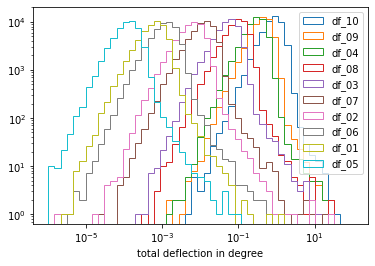

In [4]:
bins = np.logspace(-6, 2, 50)
for d in df_dict:
    df = df_dict[d]
    plt.hist(df.deflection, bins=bins, histtype='step', label=d)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.legend()

argmax:  24
number events:  50000
Current CL:  0.68444
maxixum:  2.9000000000000004
lower:  2.0
upper:  3.8000000000000007
max =  2.9000000000000004  -  0.9000000000000004  +  0.9000000000000004


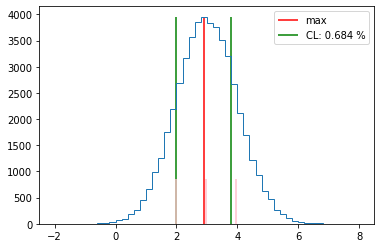

In [5]:
# get 95% smallest interval around the modal 
def get_smallest_interval_around_mode(values, bins, CL=0.68, show=False, plot=False):
    '''Determines smallest interval of x percent located around the modal value.
       Fine binnig results to more precise results.
    
    '''
    binned_counts, bin_edges = np.histogram(values, bins=bins)
    arg_max = np.argmax(binned_counts)
    n_sum = np.sum(binned_counts)
    n_sorted = np.sort(binned_counts)[::-1]
    n_argsort = np.argsort(binned_counts)[::-1]
    c = 0
    for id_argsort,i,counts in zip(range(len(n_argsort)), n_argsort, n_sorted):
        c += counts
        if c/n_sum >= CL:
            c_level = np.round(c/n_sum, 3)
            if i < arg_max: # lower limit
                # print('i < argmax')
                lower = bin_edges[i]
                while i < arg_max:
                    id_argsort += 1
                    i = n_argsort[id_argsort]
                upper = bin_edges[i]
            elif i > arg_max: 
                # print('i > argmax')
                upper = bin_edges[i]
                while i > arg_max:
                    id_argsort -= 1
                    i = n_argsort[id_argsort]
                lower = bin_edges[i]
            else:
                print('ERROR: i == argmax')
            break
    
    maximum = (bin_edges[arg_max] + bin_edges[arg_max + 1])/2
    cl = {
        'maximum': maximum,
        'lower_bound': lower,
        'upper_bound': upper,
        'CL': c_level,
    }        
    if show:
        print('argmax: ', arg_max)
        print('number events: ', np.sum(binned_counts))
        print('Current CL: ', c/n_sum)
        print('maxixum: ', maximum)
        print('lower: ', lower)
        print('upper: ', upper)
        print('max = ', maximum, ' - ', maximum-lower, ' + ',upper-maximum)
    if plot:
        plt.vlines(cl['maximum'], 1, np.max(binned_counts), color='red', label='max')
        plt.vlines(cl['lower_bound'], 1, np.max(binned_counts), color='green')
        plt.vlines(cl['upper_bound'], 1, np.max(binned_counts), color='green', label='CL: {} %'.format(cl['CL']))

    return cl

gaus = np.random.normal(3, size=50000)
bins = np.linspace(-2, 8, 51)
plt.hist(gaus, bins=bins, histtype='step')
si = get_smallest_interval_around_mode(gaus, bins=bins, CL=0.68, show=True, plot=True)

plt.vlines(np.quantile(gaus, 0.155), 0, 850, color='pink')
plt.vlines(np.quantile(gaus, 0.5), 0, 850, color='pink')
plt.vlines(np.quantile(gaus, 0.835), 0, 850, color='pink')
plt.legend()

argmax:  354
number events:  50000
Current CL:  0.95042
maxixum:  0.000690013036756923
lower:  8.668379930019774e-05
upper:  0.0022250887981283695
max =  0.000690013036756923  -  0.0006033292374567253  +  0.0015350757613714465


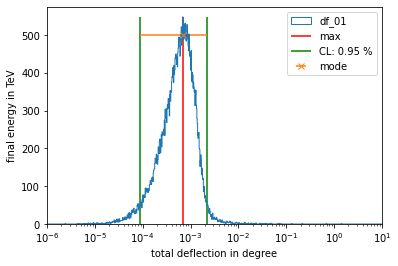

In [13]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in ['df_01']:
    df = df_dict[d]
    # si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.3, show=True, plot=True)
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=True, plot=True)
    plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode, 500, xerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.xlim(1e-6, 10)
plt.legend()

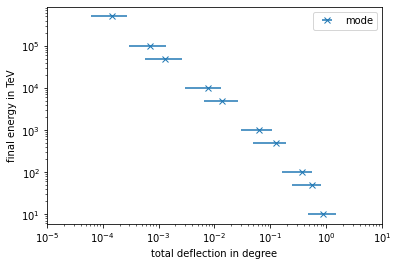

In [21]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in df_dict: # ['df_00']:
    df = df_dict[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.68, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode, E_f, xerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.xlim(1e-5, 10)
plt.legend()

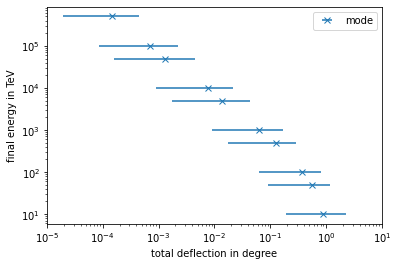

In [20]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in df_dict: # ['df_00']:
    df = df_dict[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode, E_f, xerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.xlim(1e-5, 10)
plt.legend()

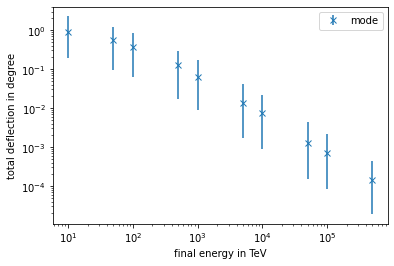

In [22]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in df_dict: # ['df_00']:
    df = df_dict[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(E_f, deflection_mode, yerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('total deflection in degree')
plt.xlabel('final energy in TeV')
plt.legend()

power params:  [ 2.52371648 -0.43610643] , errors:  [0.3446681  0.04273523]
lin params:  [ 1.17339062 -0.84939739] , errors:  [0.15075888 0.04127486]
lin params cut:  [ 1.57775077 -0.94292727] , errors:  [0.09146055 0.0227301 ]
efit params:  [-2.72885489  0.17183148  3.33401275] , errors:  [1.01269671 0.03910835 1.13466281]


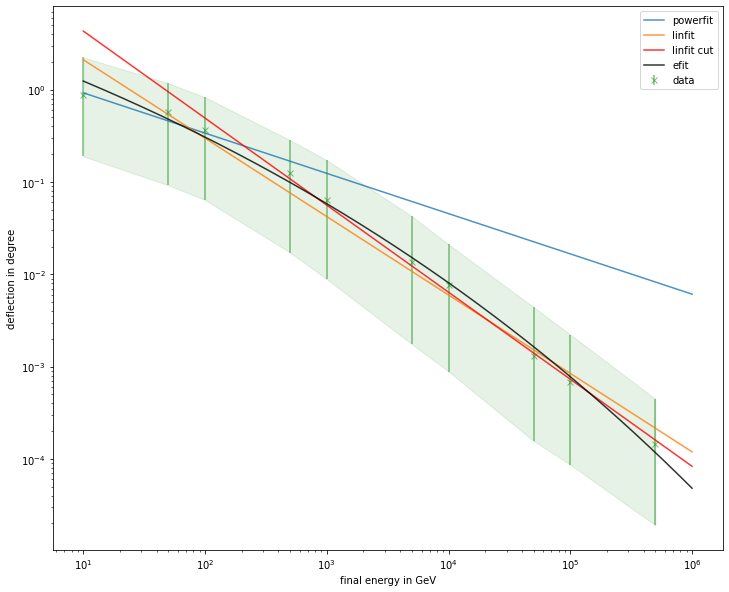

In [44]:
### fit deflection modes 
x = np.logspace(1, 6, 1000)
plt.figure(figsize=(12, 10))

# Power fit
def powerfit(x, a, b):
    return a * np.power(x, b)

params, cov = curve_fit(powerfit, E_f, deflection_mode, p0=(20, -1))
errors = np.sqrt(np.diag(cov))
print('power params: ', params, ', errors: ', errors)
plt.plot(x, powerfit(x, *params), alpha=0.8, label='powerfit')
# plt.plot(x, powerfit(x, 20, -0.88), label='händisch')


# Lin fit with all energies
def linlaw(x, a, b) :
    return a + x * b

params, cov = curve_fit(linlaw, np.log10(E_f), np.log10(deflection_mode)) 
errors = np.sqrt(np.diag(cov))
print('lin params: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), alpha=0.8, label='linfit')

# Lin fit without 10 GeV and 50 GeV (too low)
params, cov = curve_fit(linlaw, np.log10(E_f[2:]), np.log10(deflection_mode[2:])) 
errors = np.sqrt(np.diag(cov))
print('lin params cut: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), color='red', alpha=0.8, label='linfit cut')


# e-fit 
def efit(x, a, b, c):
    return a * np.exp(b * x) + c

params, cov = curve_fit(efit, np.log10(E_f), np.log10(deflection_mode))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='black', alpha=0.8, label='efit')


plt.errorbar(E_f, deflection_mode, yerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', color='green', alpha=0.5, label='data')
plt.fill_between(E_f, np.array(deflection_mode)-np.array(deflection_mode_lower), np.array(deflection_mode) + np.array(deflection_mode_upper), alpha=0.1, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('final energy in GeV')
plt.ylabel('deflection in degree')
plt.legend()